# Wavelet Phase Harmonics (for noise)

## Download

You can download the data directory `data_tutorials` using:

```bash
wget https://www.mso.anu.edu.au/~amarchal/shared/ivis/data_tutorials.zip
unzip data_tutorials.zip -d data_tutorials
rm data_tutorials.zip
```

Kindly provided by Enrico Di Teodoro (UniFI) and Karlie Noon (RSAA/ANU).

## Method
<div style="text-align: justify;">
    
> To **statistically** characterize the **image-domain response of the noise** in the visibility data, we made use of WPH statistics. 

</div>

### Read data & make noise cube

In [2]:
import glob
from tqdm import tqdm as tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from astropy.io import fits
from radio_beam import Beam
from astropy import units as u
from reproject import reproject_interp

from ivis.io import DataProcessor
from ivis.imager import Imager
from ivis.logger import logger
from ivis.utils import dutils, fourier

from ivis.models import ClassicIViS

path_ms = "./data_tutorials/ivis_data/msl_mw/" #directory of measurement sets    
path_beams = "./data_tutorials/ivis_data/BEAMS/" #directory of primary beams
path_sd = None #path single-dish data
pathout = "./data_tutorials/ivis_data/" #path where data will be packaged and stored

#REF WCS INPUT USER
filename = "./data_tutorials/ivis_data/MW-C10_mom0th_NHI.fits"
target_header = fits.open(filename)[0].header
shape = (target_header["NAXIS2"],target_header["NAXIS1"])
    
#create data processor
data_processor = DataProcessor(path_ms, path_beams, path_sd, pathout)

# pre-compute pb and interpolation grids — this can be commented after first compute
logger.disabled = True
data_processor.compute_pb_and_grid(target_header, fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits") 
logger.disabled = False

pb, grid = data_processor.read_pb_and_grid(fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits")

#Dummy sd array
sd = np.zeros(shape)
#Dummy Beam sd
beam_sd = Beam(1*u.deg, 1*u.deg, 1.e-12*u.deg)

#Read data
vis_data = data_processor.read_vis_from_scratch(uvmin=0, uvmax=np.inf,
                                                target_frequency=None,
                                                target_channel=0,
                                                extension=".ms",
                                                blocks='single',
                                                max_workers=1)

sky_model = np.zeros(shape, dtype=np.float32)

#Model visibilities with IVis forward single frequency model
image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         None,            # single dish data in unit of Jy/arcsec^2
                         None,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         sky_model,   # init array of parameters
                         0,       # maximum number of iterations
                         0,     # hyper-parameter single-dish
                         0,      # hyper-parameter regularization
                         False,    # impose a positivity constaint
                         0,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)

model_vis =  image_processor.forward_model(ClassicIViS())

#user parameters
max_its = 20
lambda_sd = 0 #not relevant here
lambda_r = 1 #Control the strength of the Laplacian filtering
device = 0#"cpu" #0 is GPU and "cpu" is CPU
positivity = False #Set to False because noise fluctuates around 0

logger.info("This might take a few minutes if using a CPU...")
logger.disabled = True

n_noise = 3 #number of noise realisations 
noise_cube = np.zeros((n_noise,shape[0],shape[1]))
for i in tqdm(np.arange(n_noise)):
    #Add noise
    fact=1 #Scale the noise.ipynbe with this if needed
    noise_real = np.random.normal(loc=0.0, scale=vis_data.sigma*fact)
    noise_imag = np.random.normal(loc=0.0, scale=vis_data.sigma*fact)
    noise = noise_real + 1j * noise_imag

    # Add realistic thermal noise to the model visibilities
    vis_data.data = model_vis + noise

    #Initial parameters (zero array)
    init_params = np.zeros(shape, dtype=np.float32)

    #create image processor
    image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish
                         lambda_r,      # hyper-parameter regularization
                         positivity,    # impose a positivity constaint
                         device,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)
    #get image
    model = ClassicIViS()
    noise_cube[i] = image_processor.process(model=model, units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"
logger.disabled = False

[2025-08-01 22:51:20 UTC] [IViS] [info] [Initialize DataProcessor ]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]
[2025-08-01 22:51:23 UTC] [IViS] [info] Processing single scheduling block.
[2025-08-01 22:51:23 UTC] [IViS] [info] Number of MS files = 5
[2025-08-01 22:51:23 UTC] [IViS] [info] Reading MS files with single thread.
[2025-08-01 22:51:23 UTC] [IViS] [info] Processing file 1/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_1_MW_chan_-32kms.ms
[2025-08-01 22:51:23 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050093 Hz | Velocity (LSRK): -32.0000000000517 km/s
[2025-08-01 22:51:23 UTC] [IViS] [info] Extracted 626313 valid baselines.
[2025-08-01 22:51:23 UTC] [IViS] [info] Time for iteration 1: 0.08s, ETA: 0.01 minutes
[2025-08-01 22:51:23 UTC] 

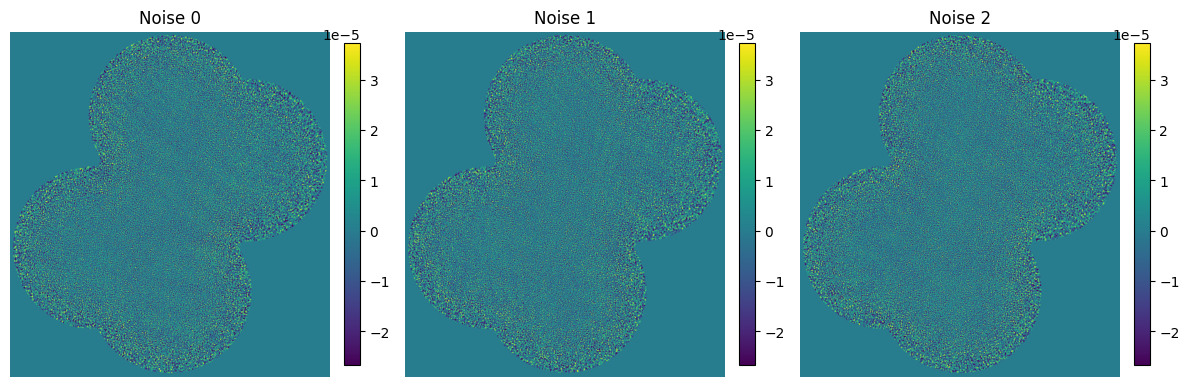

In [3]:
# Use percentile-based scaling to avoid outlier domination
subset = noise_cube[:3]
vmin = np.percentile(subset, 1)
vmax = np.percentile(subset, 99.9)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    im = axes[i].imshow(noise_cube[i], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Noise {i}')
    axes[i].axis('off')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Use WPHs to statistically characterize the noise

In [4]:
import pywph as pw
import torch

#Disable MPS explicitly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # or "cpu" only
logger.info("forcing using CPU here because of my MacOS version.")

[2025-08-01 22:53:57 UTC] [IViS] [info] forcing using CPU here because of my MacOS version.


In [5]:
#Taken from Constant Auclair notebook: https://github.com/constantauclair/CompSep/blob/main/Library/tutorial.ipynb
M, N = shape # map size
J = int(np.log2(min(M, N)))-2 # number of scales
L = 4 # number of angles
pbc = True # periodic boundary conditions
dn = 5 # number of translations
wph_model = ["S11","S00","S01","Cphase","C01","C00","L"] # list of WPH coefficients

In [6]:
logger.info("Should take ~20s.")
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device="cpu")

[2025-08-01 22:53:58 UTC] [IViS] [info] Should take ~20s.


In [7]:
wph_model = ["S11"] #Only compute power spectrum (faster)
wph_op.load_model(wph_model)

In [8]:
coeffs_list=[]
for i in tqdm(np.arange(n_noise)):
    coeffs = wph_op.apply(torch.from_numpy(noise_cube[i]).unsqueeze(0).unsqueeze(0).to("cpu"), norm=None, pbc=pbc)
    coeffs_list.append(coeffs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.23s/it]


In [9]:
np.array(coeffs_list).shape

(3, 1, 1, 672)

In [10]:
mu = np.mean(np.array(coeffs_list),(0,1,2))
std = np.std(np.array(coeffs_list),(0,1,2))

Text(0, 0.5, 'std coeffs')

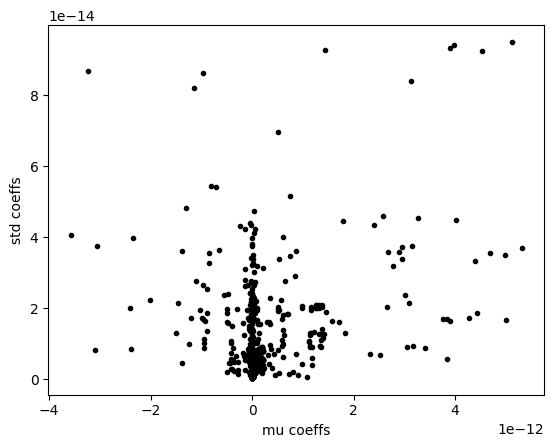

In [12]:
plt.plot(mu, std, ".k")
plt.xlabel("mu coeffs")
plt.ylabel("std coeffs")